In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

# Creating the db 

two separates db for senate and congress

In [3]:
CLIP_TRESHOLD = 40
clipping_stats_list_senate = []
clipping_stats_list_house = []

# Loop through congress files
for i in range(76, 112):
    
    "------ Loading files -------"
    
    year_str = f"{i:03}"
    base_dir_load = Path("../data/raw")

    speeches_file = base_dir_load / f"speeches/speeches_{year_str}.txt"
    map_file = base_dir_load / f"speaker_map/{year_str}_SpeakerMap.txt"
    metadata_file = base_dir_load /f"metadata/descr_{year_str}.txt"
    
    print("Processing:", speeches_file, map_file, metadata_file)
    df_speeches = pd.read_csv(speeches_file, sep="|", encoding="latin1", dtype={"speech_id": str}, on_bad_lines="skip", engine="python")
    df_map = pd.read_csv(map_file, encoding='windows-1252', delimiter="|")
    df_metadata = pd.read_csv(metadata_file, encoding='windows-1252', delimiter="|")

    # converts type
    df_speeches["speech_id"] = pd.to_numeric(df_speeches["speech_id"], errors="coerce").astype("Int64")
    df_map.chamber = pd.Categorical(df_map.chamber)
    df_map.party = pd.Categorical(df_map.party)
    
    "------ Dropping column -------"
    
    # Clean speaker map
    df_map = df_map.drop(["district", "nonvoting", "state", "gender"], axis=1)
    # Clean metadata
    df_metadata = df_metadata[['speech_id', 'date', 'char_count', 'word_count']]

    "------ Merging -------"
    
    df_merge1 = pd.merge(df_speeches, df_map, on="speech_id", how="outer")
    df_merged = pd.merge(df_merge1, df_metadata, on="speech_id", how="outer")
    
    df_merged = df_merged.dropna(subset=["speakerid"])
    df_merged['speakerid'] = df_merged['speakerid'].astype(int)
    df_merged = df_merged[df_merged['party'].isin(['D', 'R'])]
    df_merged['party'] = df_merged['party'].cat.remove_unused_categories()
    
    # Split by chamber BEFORE processing statistics
    df_senate_full = df_merged[df_merged['chamber'] == 'S'].copy()
    df_house_full = df_merged[df_merged['chamber'] == 'H'].copy()
    
    # Process Senate statistics
    count_after_basic_cleaning_senate = len(df_senate_full)
    
    # Check and remove NA in 'speech' column - Senate
    count_before_speech_na_drop_senate = len(df_senate_full)
    df_senate_full = df_senate_full.dropna(subset=['speech'])
    count_after_speech_na_drop_senate = len(df_senate_full)
    speech_na_removed_senate = count_before_speech_na_drop_senate - count_after_speech_na_drop_senate
    
    # Check and remove duplicate 'speech' entries - Senate
    count_before_duplicate_drop_senate = len(df_senate_full)
    df_senate_full = df_senate_full.drop_duplicates(subset=['speech'])
    count_after_duplicate_drop_senate = len(df_senate_full)
    duplicates_removed_senate = count_before_duplicate_drop_senate - count_after_duplicate_drop_senate

    # Clipping speeches based on word_count - Senate
    count_before_clip_senate = len(df_senate_full)
    df_senate = df_senate_full[df_senate_full['word_count'] > CLIP_TRESHOLD]
    count_after_clip_senate = len(df_senate)
    clipped_removed_senate = count_before_clip_senate - count_after_clip_senate
    
    clipping_stats_list_senate.append({
        'Congress': i,
        'Start Count (After Basic Clean)': count_after_basic_cleaning_senate,
        'Removed (Speech NA)': speech_na_removed_senate,
        'Removed (Duplicates)': duplicates_removed_senate,
        'Removed (Clipped)': clipped_removed_senate,
        'Count before Clipping': count_before_clip_senate,
        'Final Count (After Clipping)': count_after_clip_senate
    })
    
    # Process House statistics
    count_after_basic_cleaning_house = len(df_house_full)
    
    # Check and remove NA in 'speech' column - House
    count_before_speech_na_drop_house = len(df_house_full)
    df_house_full = df_house_full.dropna(subset=['speech'])
    count_after_speech_na_drop_house = len(df_house_full)
    speech_na_removed_house = count_before_speech_na_drop_house - count_after_speech_na_drop_house
    
    # Check and remove duplicate 'speech' entries - House
    count_before_duplicate_drop_house = len(df_house_full)
    df_house_full = df_house_full.drop_duplicates(subset=['speech'])
    count_after_duplicate_drop_house = len(df_house_full)
    duplicates_removed_house = count_before_duplicate_drop_house - count_after_duplicate_drop_house

    # Clipping speeches based on word_count - House
    count_before_clip_house = len(df_house_full)
    df_house = df_house_full[df_house_full['word_count'] > CLIP_TRESHOLD]
    count_after_clip_house = len(df_house)
    clipped_removed_house = count_before_clip_house - count_after_clip_house
    
    clipping_stats_list_house.append({
        'Congress': i,
        'Start Count (After Basic Clean)': count_after_basic_cleaning_house,
        'Removed (Speech NA)': speech_na_removed_house,
        'Removed (Duplicates)': duplicates_removed_house,
        'Removed (Clipped)': clipped_removed_house,
        'Count before Clipping': count_before_clip_house,
        'Final Count (After Clipping)': count_after_clip_house
    })
    
    # Rename date to year for both chambers
    df_senate = df_senate.copy()
    df_house = df_house.copy()
    
    df_senate['date'] = df_senate['date'].astype(str).str[:4].astype(int)
    df_senate.rename(columns={'date': 'year'}, inplace=True)
    
    df_house['date'] = df_house['date'].astype(str).str[:4].astype(int)
    df_house.rename(columns={'date': 'year'}, inplace=True)
    
    "------ Saving to csv -------"
    # Define relative base directory
    base_dir_merged = Path("../data/merged")
    base_dir_senate = Path("../data/merged/senate_db")
    base_dir_house = Path("../data/merged/house_db")

    # Construct full file paths
    filepath_senate = base_dir_senate / f"senate_merged_{year_str}.csv"
    filepath_house = base_dir_house / f"house_merged_{year_str}.csv"

    # Create the folder if it doesn't exist
    base_dir_senate.mkdir(parents=True, exist_ok=True)
    base_dir_house.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    df_senate.to_csv(filepath_senate, index=False)
    df_house.to_csv(filepath_house, index=False)

# Save separate statistics files
with open('clipping_stats_senate.json', 'w') as f:
    json.dump(clipping_stats_list_senate, f, indent=4)

with open('clipping_stats_house.json', 'w') as f:
    json.dump(clipping_stats_list_house, f, indent=4)

Processing: ..\data\raw\speeches\speeches_076.txt ..\data\raw\speaker_map\076_SpeakerMap.txt ..\data\raw\metadata\descr_076.txt
Processing: ..\data\raw\speeches\speeches_077.txt ..\data\raw\speaker_map\077_SpeakerMap.txt ..\data\raw\metadata\descr_077.txt
Processing: ..\data\raw\speeches\speeches_078.txt ..\data\raw\speaker_map\078_SpeakerMap.txt ..\data\raw\metadata\descr_078.txt
Processing: ..\data\raw\speeches\speeches_079.txt ..\data\raw\speaker_map\079_SpeakerMap.txt ..\data\raw\metadata\descr_079.txt
Processing: ..\data\raw\speeches\speeches_080.txt ..\data\raw\speaker_map\080_SpeakerMap.txt ..\data\raw\metadata\descr_080.txt
Processing: ..\data\raw\speeches\speeches_081.txt ..\data\raw\speaker_map\081_SpeakerMap.txt ..\data\raw\metadata\descr_081.txt
Processing: ..\data\raw\speeches\speeches_082.txt ..\data\raw\speaker_map\082_SpeakerMap.txt ..\data\raw\metadata\descr_082.txt
Processing: ..\data\raw\speeches\speeches_083.txt ..\data\raw\speaker_map\083_SpeakerMap.txt ..\data\raw

In [8]:
# Load the JSON data
with open('clipping_stats_house.json', 'r') as f:
    stats_data = json.load(f)

# Convert to DataFrame for easier manipulation
df_stats = pd.DataFrame(stats_data)

# Calculate aggregated statistics
summary_stats = {
    'Total Congresses': len(df_stats),
    'Congress Range': f"{df_stats['Congress'].min()}-{df_stats['Congress'].max()}",
    'Total Start Count (After Basic Clean)': df_stats['Start Count (After Basic Clean)'].sum(),
    'Total Removed (Speech NA)': df_stats['Removed (Speech NA)'].sum(),
    'Total Removed (Duplicates)': df_stats['Removed (Duplicates)'].sum(),
    'Total Removed (Clipped)': df_stats['Removed (Clipped)'].sum(),
    'Total Count before Clipping': df_stats['Count before Clipping'].sum(),
    'Total Final Count (After Clipping)': df_stats['Final Count (After Clipping)'].sum()
}

# Calculate percentages
total_start = summary_stats['Total Start Count (After Basic Clean)']
summary_stats['% Removed (Speech NA)'] = round((summary_stats['Total Removed (Speech NA)'] / total_start) * 100, 2)
summary_stats['% Removed (Duplicates)'] = round((summary_stats['Total Removed (Duplicates)'] / total_start) * 100, 2)
summary_stats['% Removed (Clipped)'] = round((summary_stats['Total Removed (Clipped)'] / total_start) * 100, 2)
summary_stats['% Final Retention'] = round((summary_stats['Total Final Count (After Clipping)'] / total_start) * 100, 2)

# Create summary DataFrame
summary_df = pd.DataFrame([summary_stats]).T
summary_df.columns = ['Value']

print("=== HOUSE OF REPRESENTATIVES CLIPPING STATISTICS SUMMARY ===")
print(summary_df)

print("\n=== DETAILED BREAKDOWN BY CONGRESS ===")
print(df_stats.to_string(index=False))

# Display summary statistics
print(f"\nSummary DataFrame shape: {summary_df.shape}")

# Create key insights table
insights_data = {
    'Metric': [
        'Congresses Processed',
        'Congress Range', 
        'Initial Speeches (After Basic Clean)',
        'Removed Duplicates',
        'Removed Short Speeches (< 40 words)',
        'Final Dataset Size',
        'Overall Retention Rate'
    ],
    'Value': [
        f"{len(df_stats)}",
        f"{df_stats['Congress'].min()}-{df_stats['Congress'].max()}",
        f"{total_start:,}",
        f"{summary_stats['Total Removed (Duplicates)']:,} ({summary_stats['% Removed (Duplicates)']}%)",
        f"{summary_stats['Total Removed (Clipped)']:,} ({summary_stats['% Removed (Clipped)']}%)",
        f"{summary_stats['Total Final Count (After Clipping)']:,}",
        f"{summary_stats['% Final Retention']}%"
    ]
}

insights_df = pd.DataFrame(insights_data)
print(f"\n=== KEY INSIGHTS ===")
print(insights_df.to_string(index=False))

=== HOUSE OF REPRESENTATIVES CLIPPING STATISTICS SUMMARY ===
                                         Value
Total Congresses                            36
Congress Range                          76-111
Total Start Count (After Basic Clean)  3426291
Total Removed (Speech NA)                 5401
Total Removed (Duplicates)              888119
Total Removed (Clipped)                1068139
Total Count before Clipping            2532771
Total Final Count (After Clipping)     1464632
% Removed (Speech NA)                     0.16
% Removed (Duplicates)                   25.92
% Removed (Clipped)                      31.17
% Final Retention                        42.75

=== DETAILED BREAKDOWN BY CONGRESS ===
 Congress  Start Count (After Basic Clean)  Removed (Speech NA)  Removed (Duplicates)  Removed (Clipped)  Count before Clipping  Final Count (After Clipping)
       76                           131150                  607                 36403              56179                  94140   

# Clip check & stats

In [ ]:
#samplaes check for short clip (run once before the merged block update)
year_str = f"{79:03}"
base_dir = Path("../data/merged")
house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
df = pd.read_csv(house_file)

word_count_threshold = 40 # Example: speeches with fewer than 100 words
number_of_samples = 50     # Example: how many speeches to sample
# --- Filter the DataFrame based on the word count threshold ---
df_short_speeches = df[df['word_count'] < word_count_threshold]
df_short_speeches = df_short_speeches[['speech_id', 'speech','word_count']]

sampled_speeches = df_short_speeches.sample(n=number_of_samples) # Using a random_state for reproducibility

# --- Adjust pandas display options to show full column width ---
# Store current options to restore them later (good practice)
original_max_colwidth = pd.get_option('display.max_colwidth')
original_max_columns = pd.get_option('display.max_columns') # Also good to show all columns

# Set new options
# Set max_colwidth to None to show *all* text in the column.
# Be cautious: if speeches are extremely long, this can produce massive output.
# Alternatively, set it to a large integer (e.g., 5000) to see a significant portion.
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) # Ensure all columns are shown, not just first/last

# --- Now print the sampled DataFrame (it will use the new display options) ---
print("\n--- Sampled Speeches with Full Speech Text Displayed ---")
print(sampled_speeches)

# --- IMPORTANT: Restore original pandas display options ---
pd.set_option('display.max_colwidth', original_max_colwidth)
pd.set_option('display.max_columns', original_max_columns)

print("\n--- Pandas display options restored ---")



# Fetching stats

### House of Representative stats

In [4]:
house_result_frames = []
house_speech_length_stats = []

for i in range(76, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
    df = pd.read_csv(house_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    house_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))     
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = house_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    house_party_year_stats['pct_speeches'] = (
        house_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    house_party_year_stats['pct_speakers'] = (
        house_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    house_party_year_stats = house_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = house_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        house_party_year_stats = house_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")
        
    house_party_year_stats['Congress number'] = i
    

    house_result_frames.append(house_party_year_stats.reset_index())
    
    stats = df["word_count"].describe().to_frame().T
    stats["Congress number"] = i
    house_speech_length_stats.append(stats)
    
    #print(house_party_year_stats.round(1))
    
house_speech_stats_df = pd.concat(house_speech_length_stats, ignore_index=True)
house_speech_length_df = house_speech_stats_df.round({
    'mean': 2,
    'std': 2
})

all_stats_house = pd.concat(house_result_frames, ignore_index=True)

── Processing Congress 76 ──
removed tiny-overlap year(s): [1941]
── Processing Congress 77 ──
── Processing Congress 78 ──
── Processing Congress 79 ──
── Processing Congress 80 ──
── Processing Congress 81 ──
removed tiny-overlap year(s): [1951]
── Processing Congress 82 ──
── Processing Congress 83 ──
── Processing Congress 84 ──
── Processing Congress 85 ──
── Processing Congress 86 ──
── Processing Congress 87 ──
── Processing Congress 88 ──
── Processing Congress 89 ──
── Processing Congress 90 ──
── Processing Congress 91 ──
removed tiny-overlap year(s): [1971]
── Processing Congress 92 ──
── Processing Congress 93 ──
── Processing Congress 94 ──
── Processing Congress 95 ──
── Processing Congress 96 ──
── Processing Congress 97 ──
── Processing Congress 98 ──
── Processing Congress 99 ──
── Processing Congress 100 ──
── Processing Congress 101 ──
── Processing Congress 102 ──
── Processing Congress 103 ──
── Processing Congress 104 ──
── Processing Congress 105 ──
── Processing

# Graph stats

## House

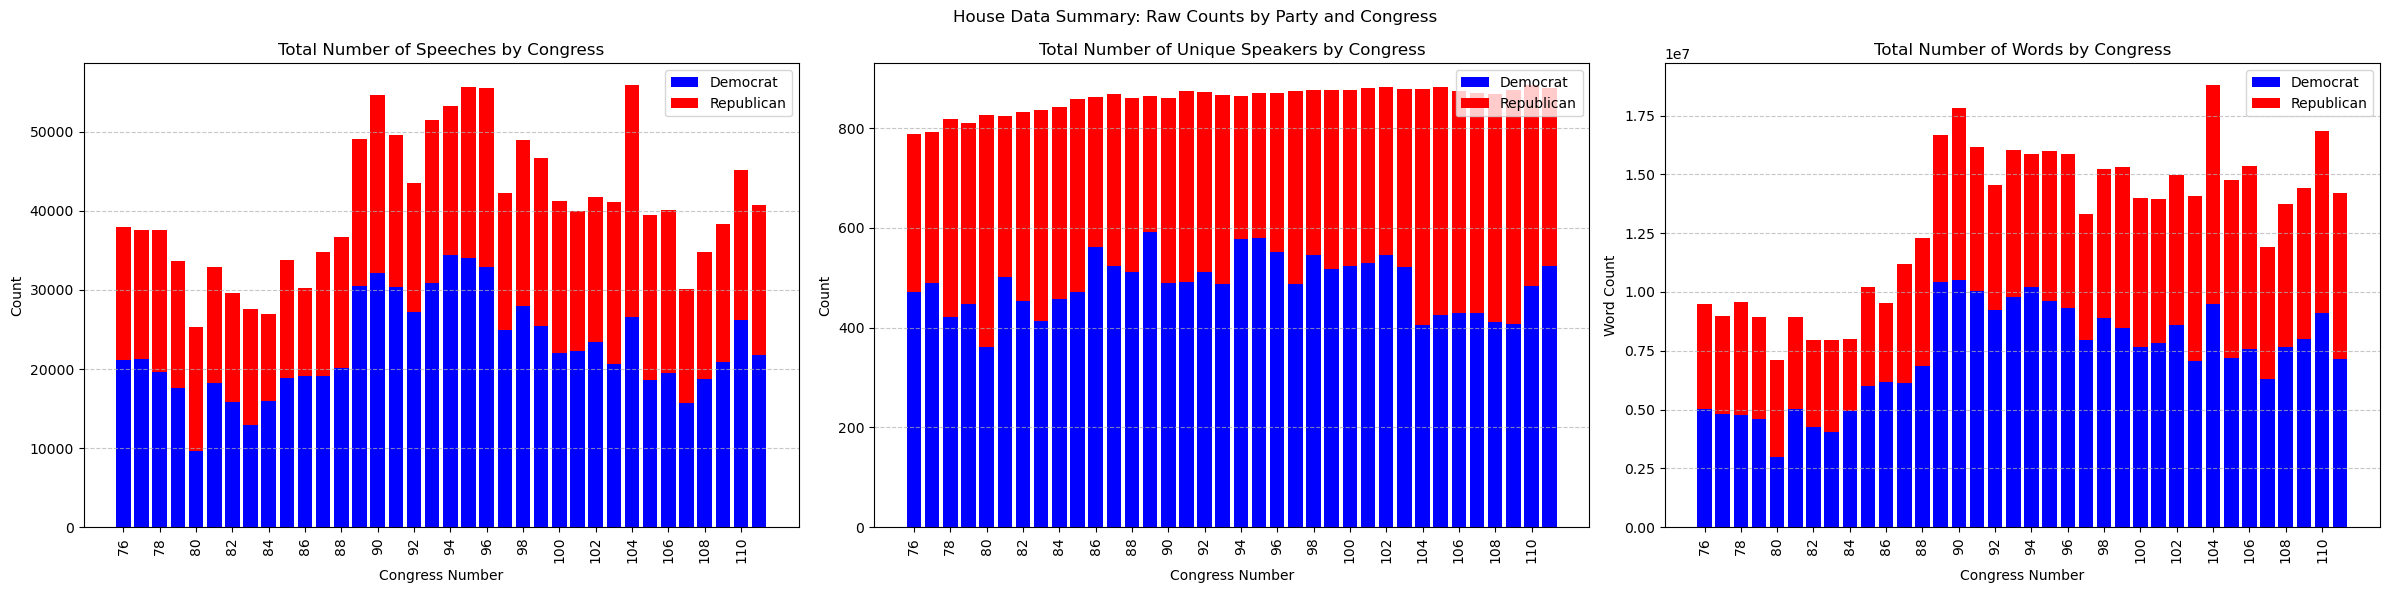

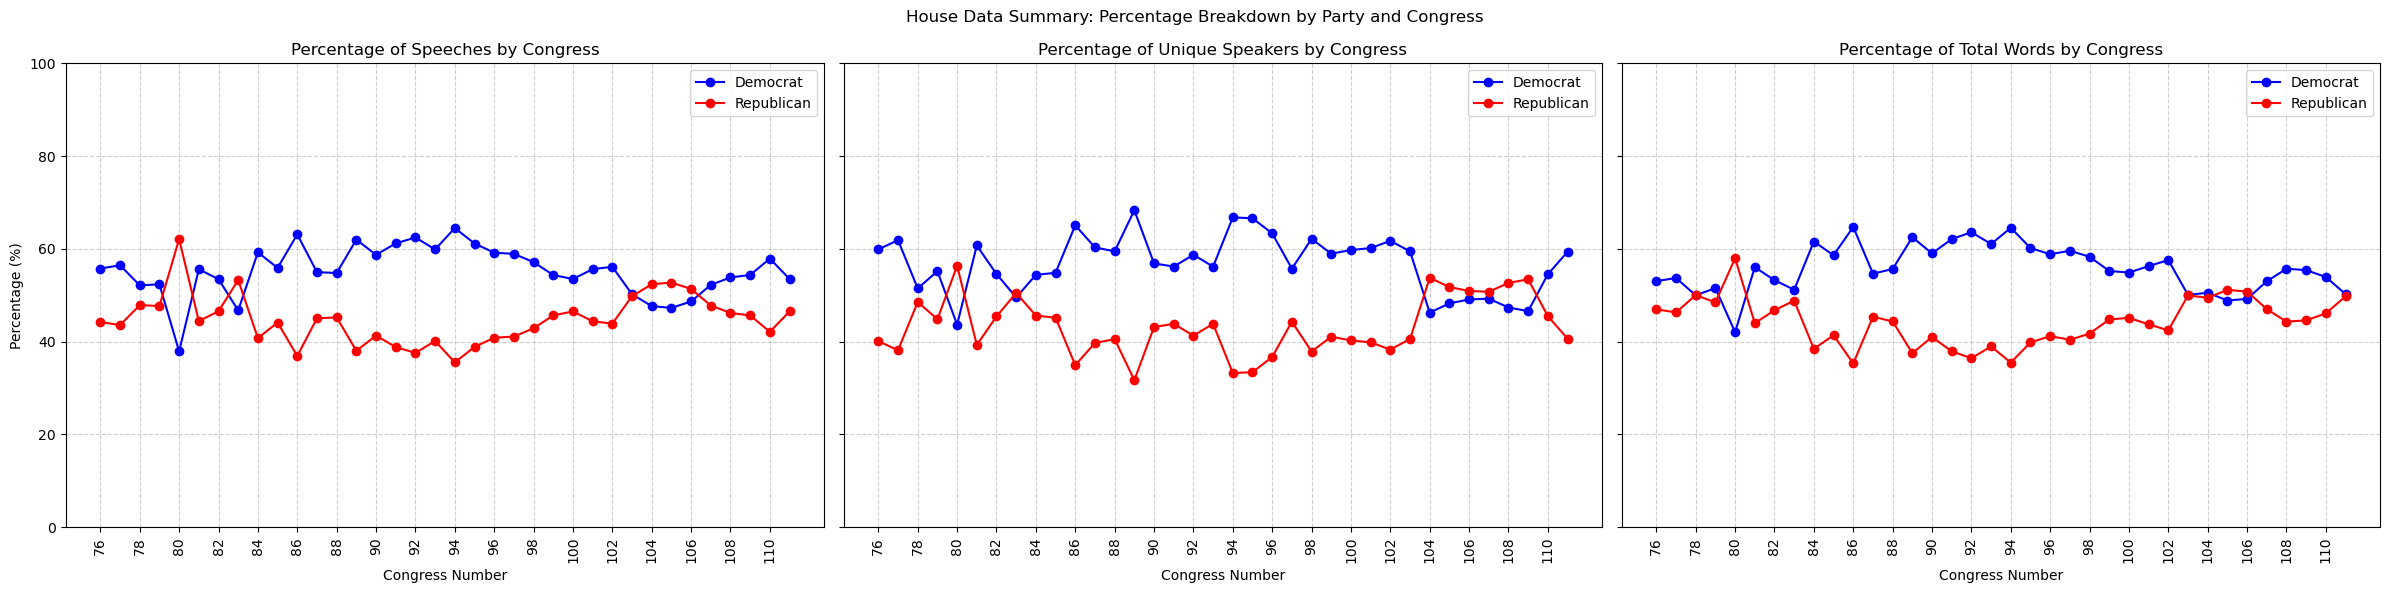

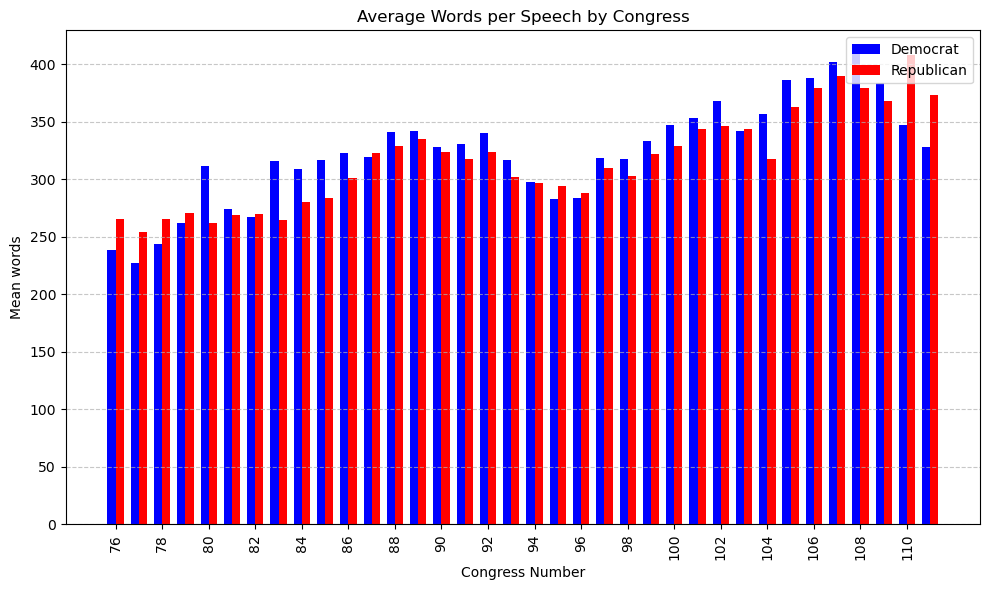

In [3]:

# Aggregate by 'Congress number' and 'party' first
# This ensures unique combinations of 'Congress number' and 'party'
agg = (
    all_stats_house
    .groupby(['Congress number', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
         num_speakers=('num_speakers', 'sum'),
         # For mean_words, taking the mean of the yearly means might not be perfectly accurate
         # if the number of speeches varies greatly by year within a congress.
         # A more accurate approach would be to calculate total words per party per congress
         # and then divide by total speeches per party per congress.
         # Let's calculate total words first and then derive mean words per congress.
         total_words_sum=('num_speeches', lambda x: (x * all_stats_house.loc[x.index, 'mean_words']).sum())
         # The lambda function above calculates the sum of (speeches * mean_words) for each group
    )
)

# Now calculate the mean_words at the Congress level from the aggregated total_words_sum
agg['mean_words'] = agg['total_words_sum'] / agg['num_speeches']

# Drop the intermediate total_words_sum column
agg = agg.drop(columns=['total_words_sum'])


# Create wide tables using the aggregated 'agg' DataFrame
speech_vals    = agg.pivot(index='Congress number', columns='party', values='num_speeches').fillna(0)
speaker_vals   = agg.pivot(index='Congress number', columns='party', values='num_speakers').fillna(0)
mean_words     = agg.pivot(index='Congress number', columns='party', values='mean_words').fillna(0)

# Calculate total words at the Congress level from the aggregated data
total_words_vals = (speech_vals * mean_words).fillna(0)


# Calculate percentages based on the Congress-level totals
congress_total_speeches = speech_vals.sum(axis=1)
congress_total_speakers = speaker_vals.sum(axis=1)
congress_total_words    = total_words_vals.sum(axis=1)

# Avoid division by zero
congress_total_speeches = congress_total_speeches.replace(0, np.nan)
congress_total_speakers = congress_total_speakers.replace(0, np.nan)
congress_total_words    = congress_total_words.replace(0, np.nan)


speech_pct = speech_vals.divide(congress_total_speeches, axis=0) * 100
speaker_pct = speaker_vals.divide(congress_total_speakers, axis=0) * 100
total_words_pct = total_words_vals.divide(congress_total_words, axis=0) * 100

# Fill NaNs created by division by zero
speech_pct = speech_pct.fillna(0)
speaker_pct = speaker_pct.fillna(0)
total_words_pct = total_words_pct.fillna(0)


# Ensure both parties are present in all tables after pivoting and calculations
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, total_words_vals, total_words_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

# Use 'Congress number' for x-axis labels and positions
congress_numbers = speech_vals.index.astype(str)
x                = np.arange(len(congress_numbers)) # numeric x‑positions

# Sort columns to ensure consistent order for stacking (e.g., Democrat then Republican)
party_order = ['Democrat', 'Republican']
speech_vals = speech_vals[party_order]
speaker_vals = speaker_vals[party_order]
total_words_vals = total_words_vals[party_order]
speech_pct = speech_pct[party_order]
speaker_pct = speaker_pct[party_order]
total_words_pct = total_words_pct[party_order]
mean_words = mean_words[party_order]


# --- Plotting Raw Counts (3 plots) ---
fig_raw, axes_raw = plt.subplots(1, 3, figsize=(24, 6), sharex=True) # Shared x-axis

# Plot Raw Speeches (Stacked Bar)
axes_raw[0].bar(x, speech_vals['Democrat'], color='blue', label='Democrat')
axes_raw[0].bar(x, speech_vals['Republican'], bottom=speech_vals['Democrat'], color='red', label='Republican')
axes_raw[0].set_title('Total Number of Speeches by Congress')
axes_raw[0].set_ylabel('Count')
axes_raw[0].legend(loc='upper right')
axes_raw[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Unique Speakers (Stacked Bar)
axes_raw[1].bar(x, speaker_vals['Democrat'], color='blue', label='Democrat')
axes_raw[1].bar(x, speaker_vals['Republican'], bottom=speaker_vals['Democrat'], color='red', label='Republican')
axes_raw[1].set_title('Total Number of Unique Speakers by Congress')
axes_raw[1].set_ylabel('Count')
axes_raw[1].legend(loc='upper right')
axes_raw[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Raw Total Words (Stacked Bar)
axes_raw[2].bar(x, total_words_vals['Democrat'], color='blue', label='Democrat')
axes_raw[2].bar(x, total_words_vals['Republican'], bottom=total_words_vals['Democrat'], color='red', label='Republican')
axes_raw[2].set_title('Total Number of Words by Congress')
axes_raw[2].set_ylabel('Word Count')
axes_raw[2].legend(loc='upper right')
axes_raw[2].grid(axis='y', linestyle='--', alpha=0.7)

# Configure X-axis for Raw Counts figure
tick_pos = x[::2] # Show every 2nd Congress number
tick_labels = congress_numbers[::2]
for ax in axes_raw:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90) # Rotate labels for readability
    ax.set_xlabel('Congress Number')

fig_raw.suptitle('House Data Summary: Raw Counts by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Percentages (3 plots) ---
fig_pct, axes_pct = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True) # Shared x and y-axis (0-100%)

# Plot Percentage of Speeches (Line plot)
axes_pct[0].plot(x, speech_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[0].plot(x, speech_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[0].set_title('Percentage of Speeches by Congress')
axes_pct[0].set_ylabel('Percentage (%)')
axes_pct[0].set_ylim(0, 100) # Set y-axis limits from 0 to 100
axes_pct[0].legend(loc='upper right')
axes_pct[0].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Unique Speakers (Line plot)
axes_pct[1].plot(x, speaker_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[1].plot(x, speaker_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[1].set_title('Percentage of Unique Speakers by Congress')
# axes_pct[1].set_ylabel('Percentage (%)') # sharey=True
axes_pct[1].set_ylim(0, 100)
axes_pct[1].legend(loc='upper right')
axes_pct[1].grid(True, linestyle='--', alpha=0.6)

# Plot Percentage of Total Words (Line plot)
axes_pct[2].plot(x, total_words_pct['Democrat'], marker='o', color='blue', label='Democrat')
axes_pct[2].plot(x, total_words_pct['Republican'], marker='o', color='red', label='Republican')
axes_pct[2].set_title('Percentage of Total Words by Congress')
# axes_pct[2].set_ylabel('Percentage (%)') # sharey=True
axes_pct[2].set_ylim(0, 100)
axes_pct[2].legend(loc='upper right')
axes_pct[2].grid(True, linestyle='--', alpha=0.6)

# Configure X-axis for Percentage plots figure
for ax in axes_pct:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Congress Number')
    # Grid already added

fig_pct.suptitle('House Data Summary: Percentage Breakdown by Party and Congress')
plt.tight_layout()
plt.show()


# --- Plotting Average Words per Speech (Separate plot as it's a mean) ---
# Use a side-by-side bar plot for this
fig_avg_words, ax_avg_words = plt.subplots(figsize=(10, 6))
bar_w = 0.35
ax_avg_words.bar(x - bar_w/2, mean_words['Democrat'], width=bar_w, color='blue', label='Democrat')
ax_avg_words.bar(x + bar_w/2, mean_words['Republican'], width=bar_w, color='red', label='Republican')
ax_avg_words.set_title('Average Words per Speech by Congress')
ax_avg_words.set_ylabel('Mean words')
ax_avg_words.set_xticks(tick_pos)
ax_avg_words.set_xticklabels(tick_labels, rotation=90)
ax_avg_words.set_xlabel('Congress Number')
ax_avg_words.legend(loc='upper right')
ax_avg_words.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


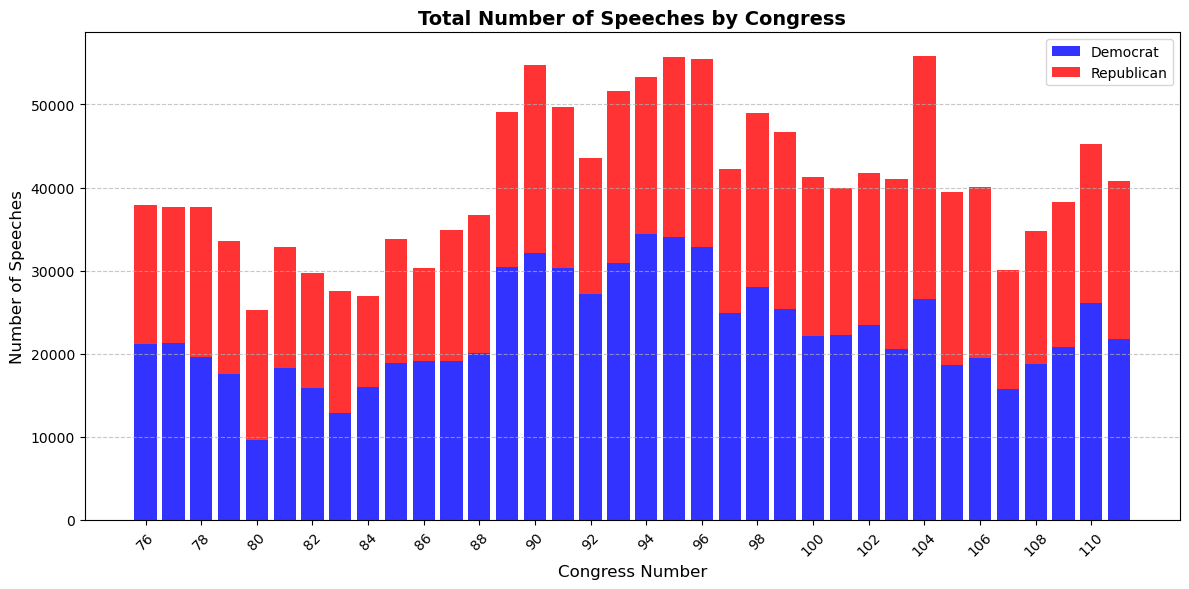

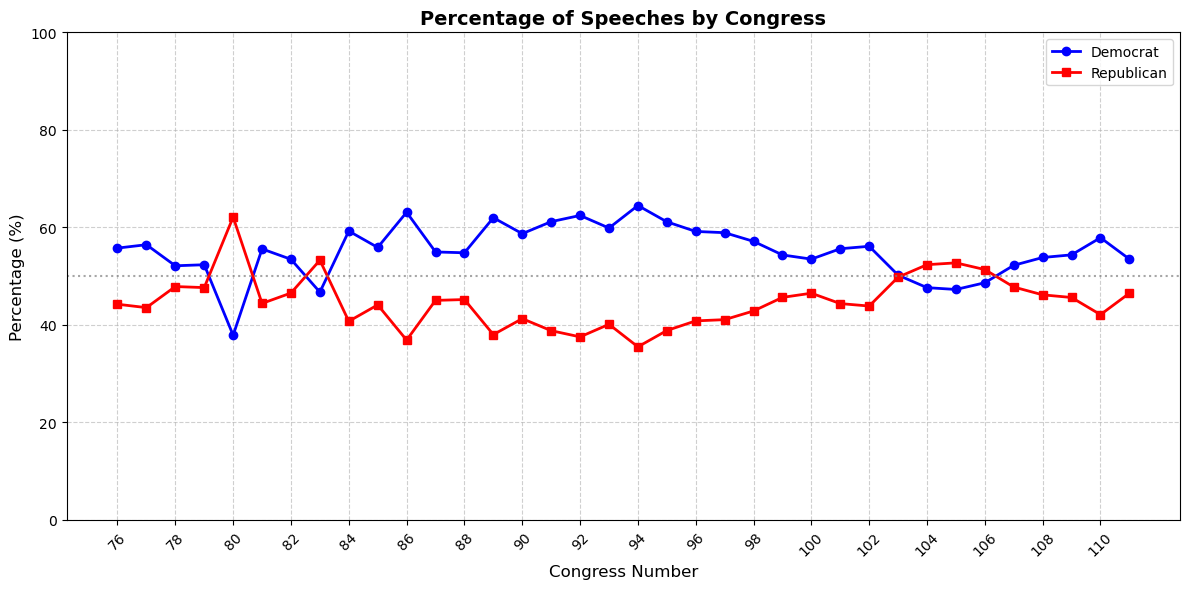

=== DATA QUALITY CHECK ===
Percentage sums across Congresses:
Min sum: 100.00%
Max sum: 100.00%
Average sum: 100.00%
Congresses not summing to 100%: 0

=== SPEECH PERCENTAGE SUMMARY STATISTICS ===
             Statistic Democratic Value Republican Value Congress Number
           Maximum (%)            64.49            62.11              94
           Minimum (%)            37.89            35.51              80
           Average (%)            55.24            44.76               -
Standard Deviation (%)             5.38             5.38               -

=== SPEECH COUNT STATISTICS ===
Total number of Congress sessions analyzed: 36
Average speeches per Congress: 40676.47
Standard deviation of speeches per Congress: 8713.64
Minimum speeches in a Congress: 25281 (Congress 80)
Maximum speeches in a Congress: 55880 (Congress 104)
Range of speeches per Congress: 30599

=== VERIFICATION ===
Democratic average: 55.24%
Republican average: 44.76%
Sum of averages: 100.00%

=== 5 MOST IMBALANCE

In [6]:
# Aggregate by 'Congress number' and 'party' first
# This ensures unique combinations of 'Congress number' and 'party'
agg = (
    all_stats_house
    .groupby(['Congress number', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
         num_speakers=('num_speakers', 'sum'),
         # For mean_words, taking the mean of the yearly means might not be perfectly accurate
         # if the number of speeches varies greatly by year within a congress.
         # A more accurate approach would be to calculate total words per party per congress
         # and then divide by total speeches per party per congress.
         # Let's calculate total words first and then derive mean words per congress.
         total_words_sum=('num_speeches', lambda x: (x * all_stats_house.loc[x.index, 'mean_words']).sum())
         # The lambda function above calculates the sum of (speeches * mean_words) for each group
    )
)

# Now calculate the mean_words at the Congress level from the aggregated total_words_sum
agg['mean_words'] = agg['total_words_sum'] / agg['num_speeches']

# Drop the intermediate total_words_sum column
agg = agg.drop(columns=['total_words_sum'])

# Create wide tables using the aggregated 'agg' DataFrame
speech_vals = agg.pivot(index='Congress number', columns='party', values='num_speeches').fillna(0)

# Calculate percentages based on the Congress-level totals
congress_total_speeches = speech_vals.sum(axis=1)

# Avoid division by zero
congress_total_speeches = congress_total_speeches.replace(0, np.nan)

speech_pct = speech_vals.divide(congress_total_speeches, axis=0) * 100

# Fill NaNs created by division by zero
speech_pct = speech_pct.fillna(0)

# Ensure both parties are present in all tables after pivoting and calculations
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speech_pct]:
        if p not in tbl.columns:
            tbl[p] = 0

# Use 'Congress number' for x-axis labels and positions
congress_numbers = speech_vals.index.astype(str)
x = np.arange(len(congress_numbers)) # numeric x‑positions

# Sort columns to ensure consistent order for stacking (e.g., Democrat then Republican)
party_order = ['Democrat', 'Republican']
speech_vals = speech_vals[party_order]
speech_pct = speech_pct[party_order]

# --- Calculate speech statistics for additional information ---
total_speeches_per_congress = speech_vals.sum(axis=1)
avg_speeches_per_congress = total_speeches_per_congress.mean()
std_speeches_per_congress = total_speeches_per_congress.std()

# --- Create first plot: Raw Speeches (Stacked Bar) ---
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 6))

ax1.bar(x, speech_vals['Democrat'], color='blue', label='Democrat', alpha=0.8)
ax1.bar(x, speech_vals['Republican'], bottom=speech_vals['Democrat'], color='red', label='Republican', alpha=0.8)
ax1.set_title('Total Number of Speeches by Congress', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Speeches', fontsize=12)
ax1.set_xlabel('Congress Number', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Configure X-axis
tick_pos = x[::2] # Show every 2nd Congress number
tick_labels = congress_numbers[::2]
ax1.set_xticks(tick_pos)
ax1.set_xticklabels(tick_labels, rotation=45)

# Statistics will be printed to console instead of on plot

plt.tight_layout()
plt.show()

# --- Create second plot: Percentage of Speeches (Line plot) ---
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))

ax2.plot(x, speech_pct['Democrat'], marker='o', color='blue', label='Democrat', linewidth=2, markersize=6)
ax2.plot(x, speech_pct['Republican'], marker='s', color='red', label='Republican', linewidth=2, markersize=6)
ax2.set_title('Percentage of Speeches by Congress', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xlabel('Congress Number', fontsize=12)
ax2.set_ylim(0, 100) # Set y-axis limits from 0 to 100
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.6)

# Add horizontal line at 50% for reference
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.7, label='50% line')

# Configure X-axis
ax2.set_xticks(tick_pos)
ax2.set_xticklabels(tick_labels, rotation=45)

# Statistics will be printed to console instead of on plot

plt.tight_layout()
plt.show()

# --- Summary Statistics Table for Democratic Speech Percentage ---
dem_pct_series = speech_pct['Democrat']
rep_pct_series = speech_pct['Republican']

# Check if percentages sum to 100 for each Congress
percentage_sums = speech_pct.sum(axis=1)
print("=== DATA QUALITY CHECK ===")
print(f"Percentage sums across Congresses:")
print(f"Min sum: {percentage_sums.min():.2f}%")
print(f"Max sum: {percentage_sums.max():.2f}%") 
print(f"Average sum: {percentage_sums.mean():.2f}%")
print(f"Congresses not summing to 100%: {len(percentage_sums[percentage_sums != 100.0])}")

# Calculate summary statistics
summary_stats = {
    'Statistic': ['Maximum (%)', 'Minimum (%)', 'Average (%)', 'Standard Deviation (%)'],
    'Democratic Value': [
        f"{dem_pct_series.max():.2f}",
        f"{dem_pct_series.min():.2f}", 
        f"{dem_pct_series.mean():.2f}",
        f"{dem_pct_series.std():.2f}"
    ],
    'Republican Value': [
        f"{rep_pct_series.max():.2f}",
        f"{rep_pct_series.min():.2f}", 
        f"{rep_pct_series.mean():.2f}",
        f"{rep_pct_series.std():.2f}"
    ],
    'Congress Number': [
        dem_pct_series.idxmax(),  # Congress with maximum percentage
        dem_pct_series.idxmin(),  # Congress with minimum percentage
        '-',  # Not applicable for average
        '-'   # Not applicable for std dev
    ]
}

summary_df = pd.DataFrame(summary_stats)

print(f"\n=== SPEECH PERCENTAGE SUMMARY STATISTICS ===")
print(summary_df.to_string(index=False))

# --- NEW: Speech Count Statistics ---
print(f"\n=== SPEECH COUNT STATISTICS ===")
print(f"Total number of Congress sessions analyzed: {len(congress_numbers)}")
print(f"Average speeches per Congress: {avg_speeches_per_congress:.2f}")
print(f"Standard deviation of speeches per Congress: {std_speeches_per_congress:.2f}")
print(f"Minimum speeches in a Congress: {total_speeches_per_congress.min():.0f} (Congress {total_speeches_per_congress.idxmin()})")
print(f"Maximum speeches in a Congress: {total_speeches_per_congress.max():.0f} (Congress {total_speeches_per_congress.idxmax()})")
print(f"Range of speeches per Congress: {total_speeches_per_congress.max() - total_speeches_per_congress.min():.0f}")

print(f"\n=== VERIFICATION ===")
print(f"Democratic average: {dem_pct_series.mean():.2f}%")
print(f"Republican average: {rep_pct_series.mean():.2f}%")
print(f"Sum of averages: {dem_pct_series.mean() + rep_pct_series.mean():.2f}%")

# --- NEW: Calculate Imbalance and Create Most/Least Imbalanced Table ---
# Calculate imbalance as the absolute difference from 50-50 split
# Higher values indicate more imbalance
imbalance = np.abs(dem_pct_series - 50.0)

# Create a DataFrame with Congress number, percentages, and imbalance
imbalance_df = pd.DataFrame({
    'Congress': speech_pct.index,
    'Democrat_Pct': dem_pct_series.values,
    'Republican_Pct': rep_pct_series.values,
    'Imbalance': imbalance.values,
    'Dominant_Party': np.where(dem_pct_series > rep_pct_series, 'Democrat', 'Republican')
})

# Sort by imbalance to get most and least imbalanced
imbalance_sorted = imbalance_df.sort_values('Imbalance', ascending=False)

# Get top 5 most imbalanced and top 5 least imbalanced
most_imbalanced = imbalance_sorted.head(5).copy()
least_imbalanced = imbalance_sorted.tail(5).copy()

# Create formatted table
print(f"\n=== 5 MOST IMBALANCED CONGRESS SESSIONS ===")
print("Congress | Democrat% | Republican% | Imbalance | Dominant Party")
print("-" * 65)
for _, row in most_imbalanced.iterrows():
    print(f"{row['Congress']:>8} | {row['Democrat_Pct']:>8.2f} | {row['Republican_Pct']:>10.2f} | {row['Imbalance']:>8.2f} | {row['Dominant_Party']}")

print(f"\n=== 5 LEAST IMBALANCED CONGRESS SESSIONS ===")
print("Congress | Democrat% | Republican% | Imbalance | Dominant Party")
print("-" * 65)
for _, row in least_imbalanced.iterrows():
    print(f"{row['Congress']:>8} | {row['Democrat_Pct']:>8.2f} | {row['Republican_Pct']:>10.2f} | {row['Imbalance']:>8.2f} | {row['Dominant_Party']}")

# Additional imbalance statistics
print(f"\n=== IMBALANCE STATISTICS ===")
print(f"Average imbalance: {imbalance.mean():.2f} percentage points")
print(f"Maximum imbalance: {imbalance.max():.2f} percentage points (Congress {imbalance.idxmax()})")
print(f"Minimum imbalance: {imbalance.min():.2f} percentage points (Congress {imbalance.idxmin()})")
print(f"Standard deviation of imbalance: {imbalance.std():.2f} percentage points")